In [1]:
import os
import json
from matplotlib import pyplot as plt
import numpy as np
from datascience import *
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

ModuleNotFoundError: No module named 'datascience'

In [ ]:
timestamps_dir = r"/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps"
timestamps = [os.path.join(timestamps_dir, ts) for ts in os.listdir(timestamps_dir)]
timestamps[1]

In [ ]:
def interpolate(time_remaining):

    time_remaining = time_remaining.copy()
    fps = 30
    multiplier = 0
    decreasing = False

    for i in range(len(time_remaining) - 1):
        current, next_value = time_remaining[i], time_remaining[i + 1]
        peak_value = time_remaining[min(i + fps, len(time_remaining) - 1)]

        if current == 0:
            continue

        decreasing = peak_value < current
        if decreasing:
            if multiplier > 30:
                multiplier, decreasing = 0, False
                continue

            time_remaining[i] -= round((1/30) * multiplier, 2)
            multiplier = 0 if next_value < current else multiplier + 1
        # else:
        #     time_remaining[i] = 0

    return time_remaining

In [ ]:
import json

def update_time_remaining(remove_indices, time_remaining):
    for idx, remove in enumerate(remove_indices):
        if remove:
            # Find nearest neighbor with remove == 0
            left_idx = idx - 1
            right_idx = idx + 1
            while left_idx >= 0 and remove_indices[left_idx]:
                left_idx -= 1
            while right_idx < len(remove_indices) and remove_indices[right_idx]:
                right_idx += 1
            # Choose the closest valid neighbor
            if left_idx >= 0 and (right_idx >= len(remove_indices) or (idx - left_idx) <= (right_idx - idx)):
                time_remaining[idx] = time_remaining[left_idx]
            elif right_idx < len(remove_indices):
                time_remaining[idx] = time_remaining[right_idx]

def get_time_remaining_from_timestamps(fp):
    with open(fp, 'r') as f:
        data = json.load(f)
    return np.array([v['time_remaining'] if v['time_remaining'] is not None else 0 for v in data.values()])

def moving_average(x, window):
    return np.convolve(x, np.ones(window), 'valid') / window

def normalize(arr):
    _min, _max = arr.min(), arr.max()
    return (arr - _min) / (_max - _min)

def denoise_time_remaining(time_remaining):
    def update_time_remaining(remove_indices, time_remaining):
        valid_indices = np.where(remove_indices == 0)[0]
        for idx in np.where(remove_indices)[0]:
            nearest_valid_index = valid_indices[np.argmin(np.abs(valid_indices - idx))]
            time_remaining[idx] = time_remaining[nearest_valid_index]

    time_remaining = np.array(time_remaining)
    time_remaining_og = time_remaining.copy()
    expected = np.linspace(0, 720, len(time_remaining), endpoint=False)[::-1]
    norm_expected_diff = normalize(np.abs(expected - time_remaining_og))
    remove_indices = (norm_expected_diff > 0.5).astype(int)
    update_time_remaining(remove_indices, time_remaining)

    for window in [1000, 500]:
        if len(time_remaining) > window:
            mvg_avg = moving_average(time_remaining, window)
            padded_avg = np.pad(mvg_avg, (window // 2, window - window // 2 - 1), mode='edge')
            norm_diff = normalize(np.abs(time_remaining - padded_avg))
            remove_indices = (norm_diff > 0.5).astype(int)
            update_time_remaining(remove_indices, time_remaining)

    for window in [50, 10, 5]:
        if len(time_remaining) > window:
            mvg_avg = moving_average(time_remaining, window)
            padded_avg = np.pad(mvg_avg, (window // 2, window - window // 2 - 1), mode='edge')
            norm_diff = normalize(np.abs(time_remaining - padded_avg))
            remove_indices = (norm_diff > 0.01).astype(int)
            update_time_remaining(remove_indices, time_remaining)

    temp_interpolated = interpolate(time_remaining)
    delta = np.gradient(temp_interpolated)
    delta_inter = normalize(moving_average(abs(delta), 7))
    remove_indices = (delta_inter > 0.1).astype(int)
    update_time_remaining(remove_indices, time_remaining)

    return time_remaining

In [ ]:
# import os
# fp = 'processed_vids.txt'
# dir_p = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamp-visualizations'
# # with open(fp, 'w') as f:
# #     vids = os.listdir(dir_p)
# #     for v in vids:
# #         f.write(v)
# #         f.write('\n')
# vids = os.listdir(dir_p)
# len(vids)

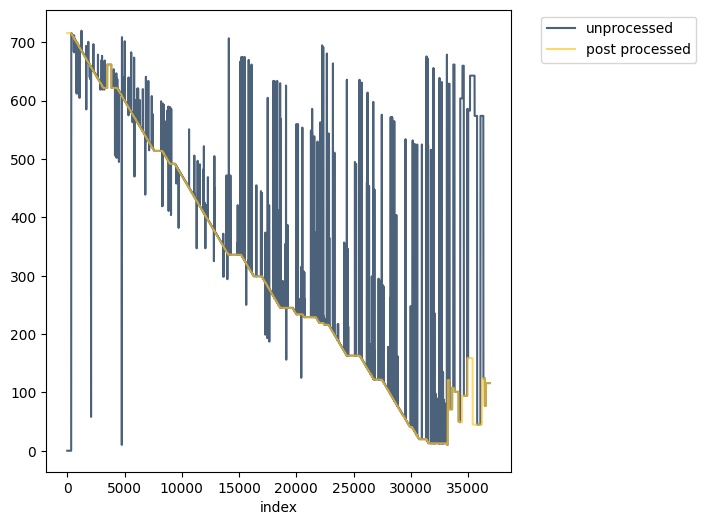

In [ ]:
i = 8
time_remaining = get_time_remaining_from_timestamps(timestamps[i])
denoised_time_remaining = denoise_time_remaining(time_remaining)
interpolated_time_remaining = interpolate(denoised_time_remaining)
delta = np.gradient(interpolated_time_remaining)
indicies = np.arange(0, len(time_remaining), 1)

t = Table().with_columns(
    'index', indicies,
    'unprocessed', time_remaining,
    'post processed', interpolated_time_remaining,
)
t.plot('index')

In [ ]:
from tqdm import tqdm

timestamps_dir = r"/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/mac_new/NBA_HUDL_data/nba-plus-statvu-dataset/timestamps"
videos_base_dir = '/Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/My Mac/720'
timestamps = [os.path.join(timestamps_dir, ts) for ts in os.listdir(timestamps_dir)]

def mean_diff(arr):
    expected = np.arange(0, 720, 720 / len(arr))[::-1]
    diffs = np.absolute(expected - arr)
    return np.mean(diffs)

ids = []
og_mean_diffs = []
pp_mean_diffs = []

for fp in tqdm(timestamps):
    if not fp.endswith('.json'):
        og_mean_diffs.append(-1)
        pp_mean_diffs.append(-1)
        id = -1
    else:
        time_remaining = get_time_remaining_from_timestamps(fp)
        
        # post processed timestamps
        denoised_time_remaining = denoise_time_remaining(time_remaining)
        interpolated_time_remaining = interpolate(denoised_time_remaining)

        _mean_diff = mean_diff(time_remaining)
        _pp_mean_diff = mean_diff(interpolated_time_remaining)

        og_mean_diffs.append(_mean_diff)
        pp_mean_diffs.append(_pp_mean_diff)
        id = fp.split("_")[3].split('/')[-1]
    ids.append(id)

  2%|▏         | 1/42 [00:00<00:09,  4.33it/s]/var/folders/r0/bvy3clwn5xqgrmr1sh2z1c0h0000gn/T/ipykernel_26348/2869637605.py:93: RuntimeWarning: invalid value encountered in divide
  return (arr - _min) / (_max - _min)
100%|██████████| 42/42 [00:13<00:00,  3.03it/s]


In [ ]:
videos_paths = [os.path.join(videos_base_dir, fp.split('/')[-1].replace('.json', '.mp4')) for fp in timestamps]
titles = [fp.split('/')[-1].replace('.json', '') for fp in timestamps]

timestamps_noise_scores: Table = Table().with_columns(
    'index', np.arange(0, len(ids)),
    'game_id', ids,
    'original_noise_score', og_mean_diffs,
    'post_processed_noise_score', pp_mean_diffs,
    'game_title', titles,
    'timestamp_path', timestamps,
    'video_path', videos_paths
).sort('post_processed_noise_score', descending=False).with_column('i', np.arange(0, timestamps_noise_scores.num_rows))
timestamps_noise_scores.show(40)

index,game_id,original_noise_score,post_processed_noise_score,game_title,timestamp_path,video_path,i
3,-1,-1,-1,.DS_Store,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,0
17,21570,40.9354,9.54161,21570_01-11-2016_2976_Memphis Grizzlies_8_Boston Celtics ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,1
22,17920,13.4724,10.8578,17920_12-03-2015_20_San Antonio Spurs_3280_Milwaukee Buc ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,2
19,17832,21.3293,10.9891,17832_12-16-2015_3174_Minnesota Timberwolves_3222_Denver ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,3
39,17923,15.5704,11.838,17923_12-03-2015_2977_Charlotte Hornets_2_Golden State W ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,4
41,17786,47.053,14.385,17786_12-23-2015_2941_Miami Heat_2932_Detroit Pistons_pe ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,5
15,17777,20.371,14.4126,17777_12-24-2015_3226_Orlando Magic_80_Houston Rockets_p ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,6
25,17878,60.5879,16.7775,17878_12-09-2015_3222_Denver Nuggets_3226_Orlando Magic_ ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,7
35,17590,25.0627,17.0865,17590_01-23-2016_2_Golden State Warriors_9_Indiana Pacer ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,8
36,17722,49.8978,21.1357,17722_01-02-2016_7_Chicago Bulls_3173_New York Knicks_pe ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,/Users/leviharris/Library/CloudStorage/GoogleDrive-levih ...,9


In [ ]:
import json
from viz import *

i = 18
_i = timestamps_noise_scores.column('index').item(i)

time_remaining = get_time_remaining_from_timestamps(timestamps[_i])
denoised_time_remaining = denoise_time_remaining(time_remaining)
interpolated_time_remaining = interpolate(denoised_time_remaining)

def update_timestamps(src_path, dst_path, time_remaining):
    with open(src_path, 'r') as f:
        timestamps = json.load(f)
    for k, v in enumerate(time_remaining):
        timestamps[str(k)]['time_remaining'] = v
    with open(dst_path, 'w') as f:
        json.dump(timestamps, f)

src_fp = timestamps[_i]
dst_path = os.path.join('demo/timestamps_dir', 'example.json')
update_timestamps(
    src_path=src_fp,
    dst_path=dst_path,
    time_remaining=interpolated_time_remaining
)

viz_dir = 'demo/viz_dir'
vp = timestamps_noise_scores.column('video_path').item(i)
tp = dst_path
out_path = os.path.join(viz_dir, timestamps_noise_scores.column('game_title').item(i)) + '.avi'
visualize_timestamps(
    vp,
    tp,
    out_path
)

Generating visualization for video at: /Users/leviharris/Library/CloudStorage/GoogleDrive-leviharris555@gmail.com/Other computers/My Mac/720/164621_12-18-2015_20_San Antonio Spurs_13_Los Angeles Clippers_period1.mp4


100%|██████████| 35941/35941 [01:41<00:00, 354.01it/s]


In [ ]:
# !pip install paddlepaddle==2.5.0
# !pip install paddleocr==2.7.0.0
# !pip install ultralytics==8.0.96
# !pip install tensorflow==2.13.0rc1
# !pip install opencv-python

In [ ]:
from ultralytics import YOLO